# SPA - J = 0 to 1
Simulating the SPA1, i.e. transferring molecules from J = 0 to J = 0 using microwave driven adiabatic passage.

## Import packages

In [21]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path
import random
import string
import time


from joblib import Parallel, delayed
import matplotlib.pyplot as plt
plt.style.use(['seaborn-deep'])
# plt.style.use(['fivethirtyeight'])
plt.rcParams['figure.figsize'] = (16,9)

# Font for labels
plt.rcParams['font.family'] = 'serif'
# Linewidths for plots
plt.rcParams['lines.linewidth'] = 1.6
plt.rcParams['lines.marker'] = ''
# Axes
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.grid'] = True
# Ticks
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Legend
plt.rcParams['legend.fontsize'] = 16

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from centrex_TlF.transitions import calculate_transition_frequency
from state_prep.electric_fields import ElectricField, E_field_ring, Ez_from_csv, Ez_from_csv_offset
from state_prep.hamiltonians import SlowHamiltonian, SlowHamiltonianOld
from state_prep.intensity_profiles import GaussianBeam, MeasuredBeam, BackgroundField
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, Intensity, MicrowaveField
from state_prep.plotters import CouplingPlotter
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [22]:
trajectory = Trajectory(Rini = np.array((0,0,-75e-3)), Vini = np.array((0,0,184.)), zfin = 200e-3)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [50]:
# #Define positions for centers of ring electrodes (in m)
# electrode_offset = 0.0
# z1 = -85.725e-3  + electrode_offset
# z2 = 85.725e-3 + electrode_offset

# #Define voltages on the rings
# V1 = 5e3*172/155
# V2 = V1*0.07

# #Define a quickly decaying function to simulate adding shielding between state prep region and detection region
# decay_function = lambda R, Z0, l: np.exp(-0.5*((R[2]-Z0)*float(R[2]>Z0)/l)**2)
# decay_tanh = lambda R,Z0,l,z_shield: .5*(1-np.tanh((R[2]-Z0)/l))

# #Define electric field as function of position
# z_shield = 0.085
# l_decay = 0.02
# z0 = 116.4/1e3

# E_R = lambda R: ((E_field_ring(R, z0 = z1, V = V1)
#                         + E_field_ring(R, z0 = z2, V = V2))*decay_tanh(R,z0,l_decay,z_shield))


# Define electric field based on finite element simulations
# Ez = Ez_from_csv_offset()
Ez = Ez_from_csv()
E_R = lambda R: np.array([0,0,Ez(R[2])])*263/263


electric_field = ElectricField(E_R, trajectory.R_t)

Max electric field: 263.46 V/cm
Electric field at z = 0: 172.39 V/cm


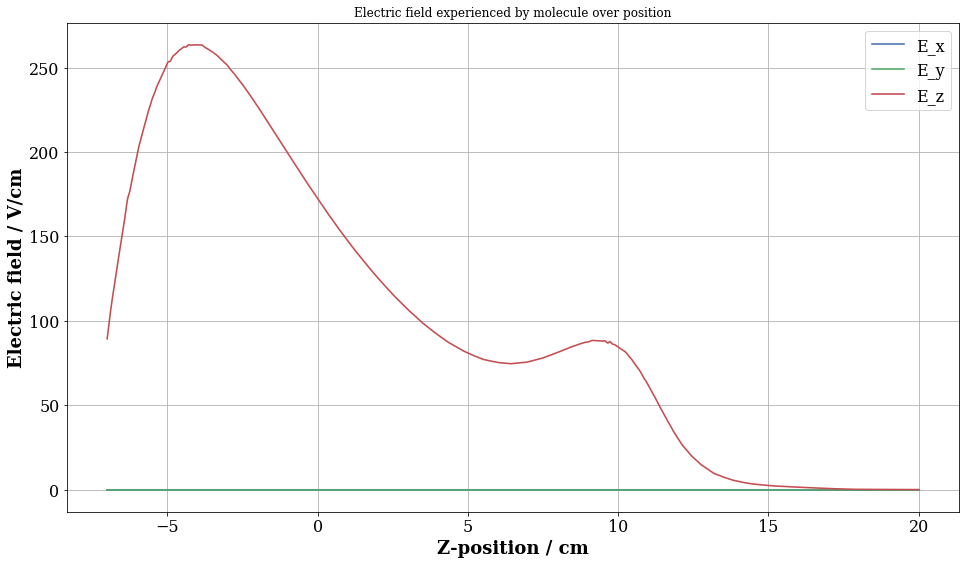

In [51]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position = True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(f"Electric field at z = 0: {E_R(np.array([0,0,0]))[2]:.2f} V/cm")

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [52]:
B = np.array((0,0,1e-4))
# B = np.array((0.2,0.45,0.1))
def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3,1)) * np.ones(R.shape)

magnetic_field = MagneticField(B_R, R_t = trajectory.R_t)

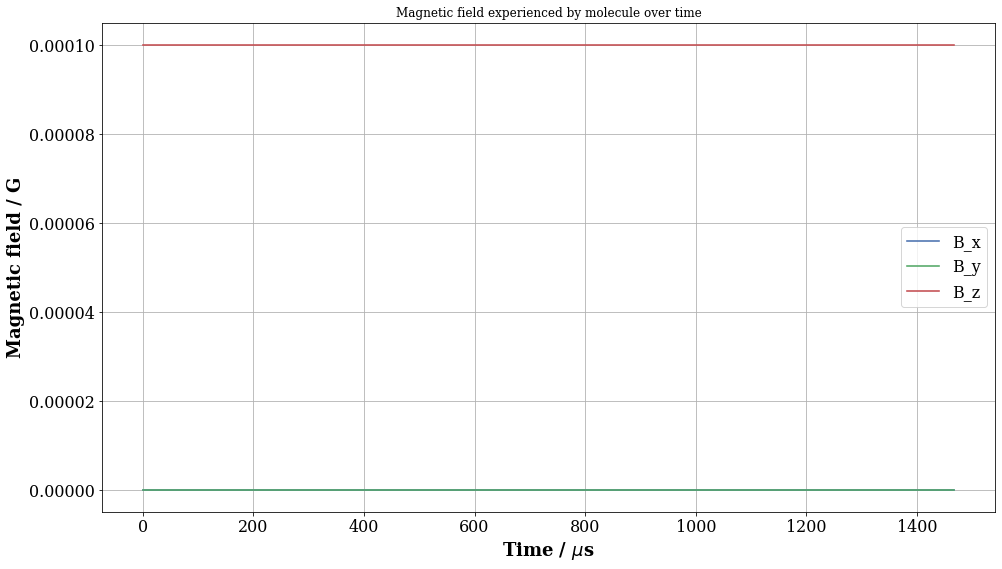

In [53]:
magnetic_field.plot(trajectory)

## Initial and final states
Define approximate initial states here.

In [54]:
#Define some useful approximate states
J0_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J0_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J0_triplet_p = 1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X')

J0_triplet_m = 1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [55]:
#Define some useful approximate states
J1_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_p = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')

J1_triplet_m = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')

J1_ppp = 1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')

J1_pmp = 1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X') 


final_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [56]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)
# hamiltonian = SlowHamiltonianOld(0, 3, trajectory, electric_field, magnetic_field, '../hamiltonians/TlF_X_state_hamiltonian0to3_2020_03_03.pickle')

## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

### J = 0 to 1 microwaves

#### Define states

In [57]:
state1 = J0_singlet
state2 = J1_singlet

#### Center position

In [58]:
R0 = np.array((0.00,0,-0.0))

In [59]:
R0.shape

(3,)

#### Polarization:

In [60]:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z + 0.0 * p_y
P_R = lambda R: p_main/np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1,0,0))

pol = Polarization(P_R, k, f_long = 1)

#### Frequency
Calculate the microwave frequency between specified states at a specific point

In [61]:
muW_freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)

In [62]:
print(f"Transition frequency at center of microwaves: {muW_freq/1e9:.5f} GHz")

Transition frequency at center of microwaves: 13.34005 GHz


#### Intensity profile:

In [63]:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)

#### Define MicrowaveField

In [64]:
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq, hamiltonian.QN) 

### J = 0 to 1 background field
Defining a field that has uniform intensity everywhere to represent microwaves randomly scattering of the vacuum chamber, windows etc

#### Polarization:

In [65]:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p = p_z + 0.4 *p_y
P_R = lambda R: p/np.sqrt(np.sum(p**2))


pol_bg = Polarization(P_R)

#### Intensity profile:

In [66]:
# Define a Gaussian intensity profile
lims = [(-1,1),(-1,1),(-1,1),]
intensity_bg = BackgroundField(lims, intensity=mf01.intensity.I_R(R0)/100)

#### Define MicrowaveField

In [67]:
mf01_bg = MicrowaveField(0, 1, intensity_bg, pol_bg, muW_freq, hamiltonian.QN, background_field=True) 

### Define list of microwave fields

In [68]:
microwave_fields = [mf01, mf01_bg]

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [69]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian, microwave_fields)

In [70]:
# Set microwave parameters
## Center postion
R0 = np.array([0.00,0,-0.0])

## Sigma
mf01.intensity.sigma = 1.0*25.4e-3/(2*np.sqrt(2*np.log(2)))

## Frequency
freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
detuning = -0e6
mf01.set_frequency(freq + detuning)
mf01_bg.set_frequency(freq + detuning)
mf01.set_position(R0)

## Power
# mf01.calculate_microwave_power(state1, state2, 2*np.pi*100e3, R0)
mf01.set_power(2e-4)
mf01_bg.intensity.intensity = mf01.intensity.I_R(R0)/70*1


# Molecule parameters
trajectory.Rini = np.array([0,0.00,-70e-3])
trajectory.Vini = np.array([0,0,184])

In [71]:
result = simulator.run(N_steps = 10000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:29<00:00, 340.88it/s]


## Plot results

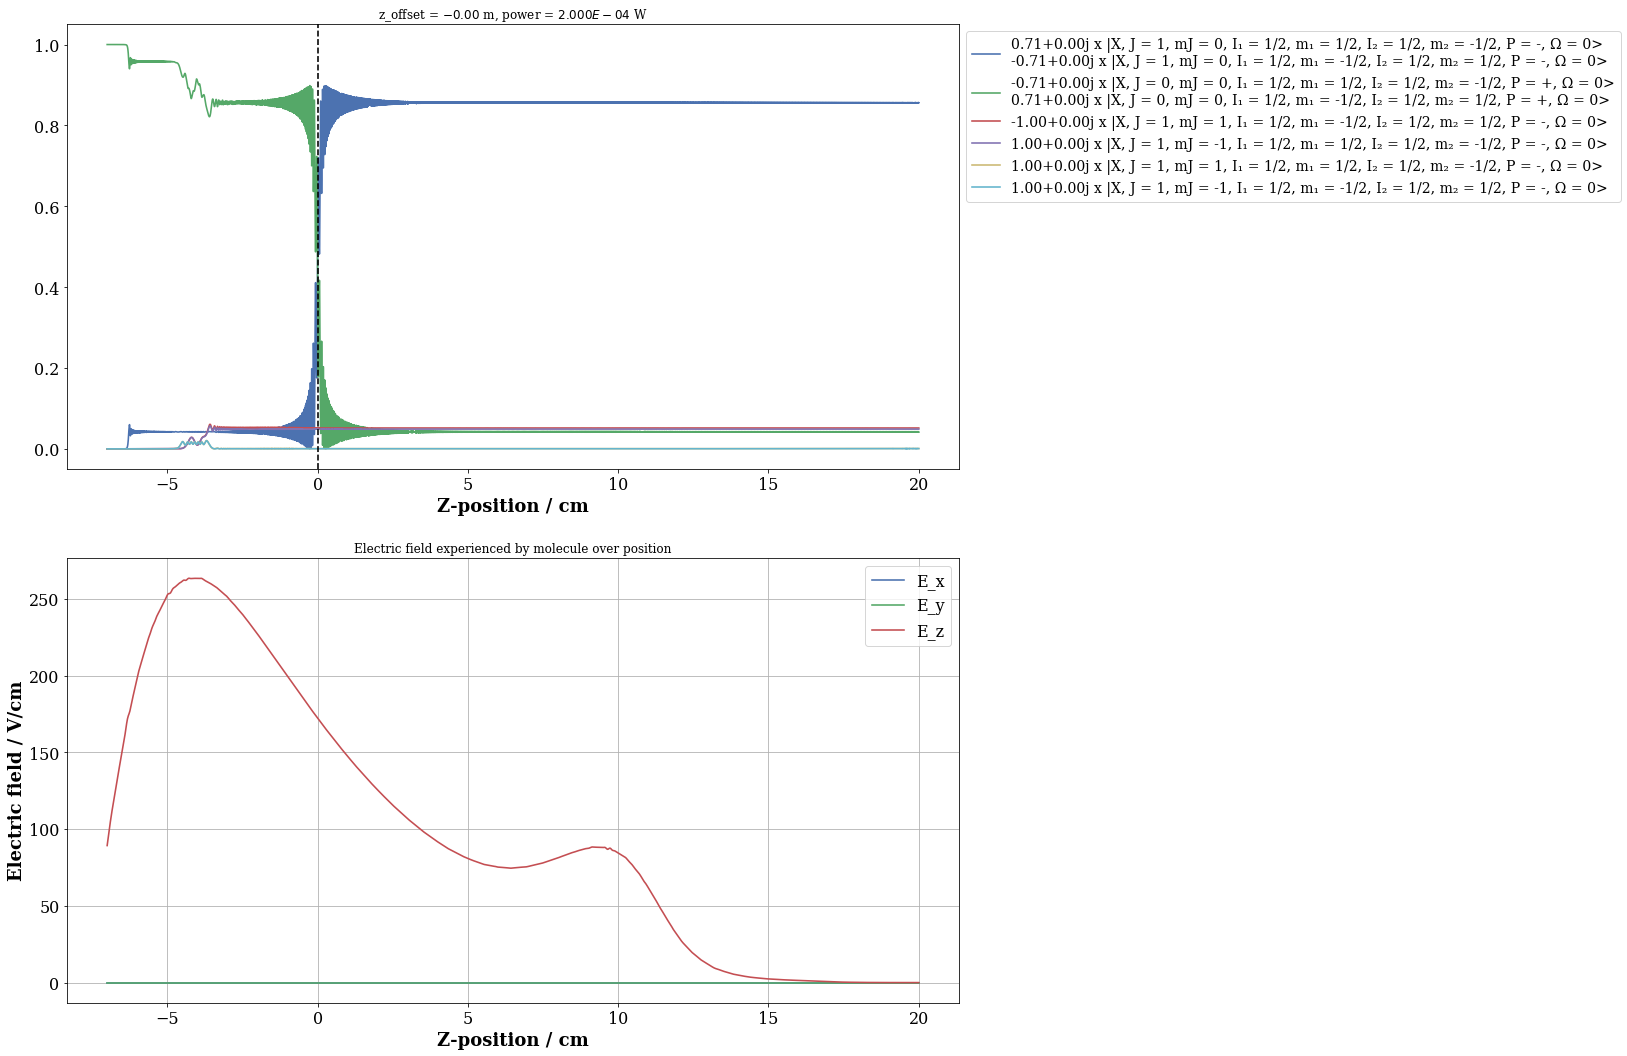

In [72]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N = 6)
fig, (ax, ax2) = plt.subplots(2,1, figsize = (16,18))
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, position = True)
ax.legend(fontsize = 14, bbox_to_anchor = (1.,1))
ax.axvline(x = R0[2]*1e2, ls ='--', c = 'k')
ax.set_title(f"z_offset = ${R0[2]:.2f}$ m, power = ${mf01.intensity.power:.3E}$ W")
ax.grid()

_ = electric_field.plot(trajectory, position=True, ax = ax2)

### Plot detunings
Plot the detunings for J = 0 to 1 for different $\Delta m_J$

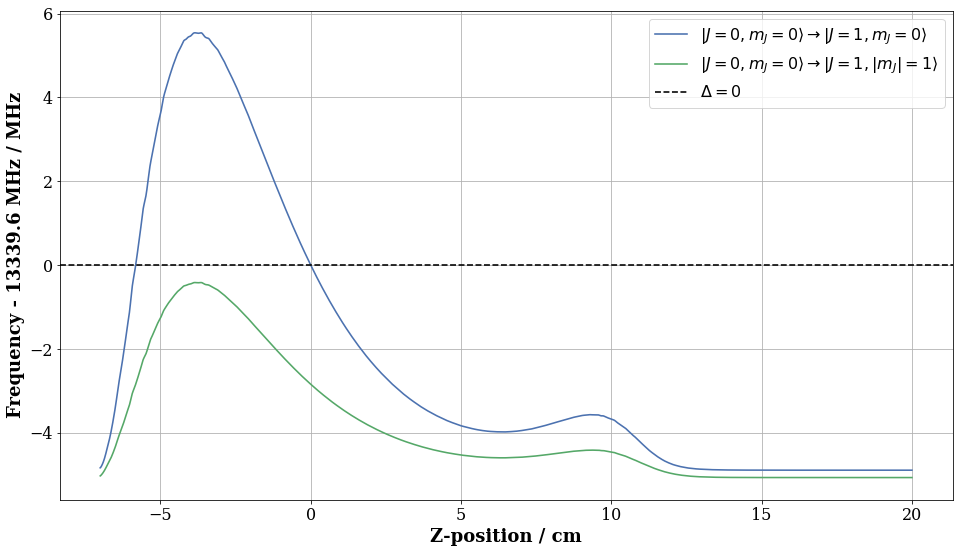

In [46]:
# Find energies
E_J0 = result.get_state_energy(J0_singlet) / (2*np.pi)
E_J1_singlet = result.get_state_energy(J1_singlet) / (2*np.pi)
E_J1_pmp = result.get_state_energy(J1_pmp) / (2*np.pi)

# Find transitions frequencies
freq_mJ0 = (E_J1_singlet - E_J0)/1e6
freq_mJ1 = (E_J1_pmp - E_J0)/1e6

# Get positions
zs = result.z_array*100

# Define frequency at z = 0
freq_0 = 13339.6

# Plot
fig, ax = plt.subplots()
ax.plot(zs, freq_mJ0-freq_0, label = r"$|J = 0, m_J = 0\rangle \rightarrow |J = 1, m_J = 0\rangle$")
ax.plot(zs, freq_mJ1-freq_0, label = r"$|J = 0, m_J = 0\rangle \rightarrow |J = 1, |m_J| = 1\rangle$")
ax.set_xlabel('Z-position / cm')
ax.set_ylabel(f'Frequency - {freq_0} MHz / MHz')
ax.axhline(0,ls='--', c='k', label = r'$\Delta = 0$')
ax.legend()

# plt.savefig(Path('G:\My Drive\CeNTREX Oskari\State preparation\SPA\Report\State preparation and diabatic transitions\Figures\EV_J01/J01_transition_freq_vs_position.pdf'))

### Plot intensity profile
Check that the longitudinal polarization appears correctly

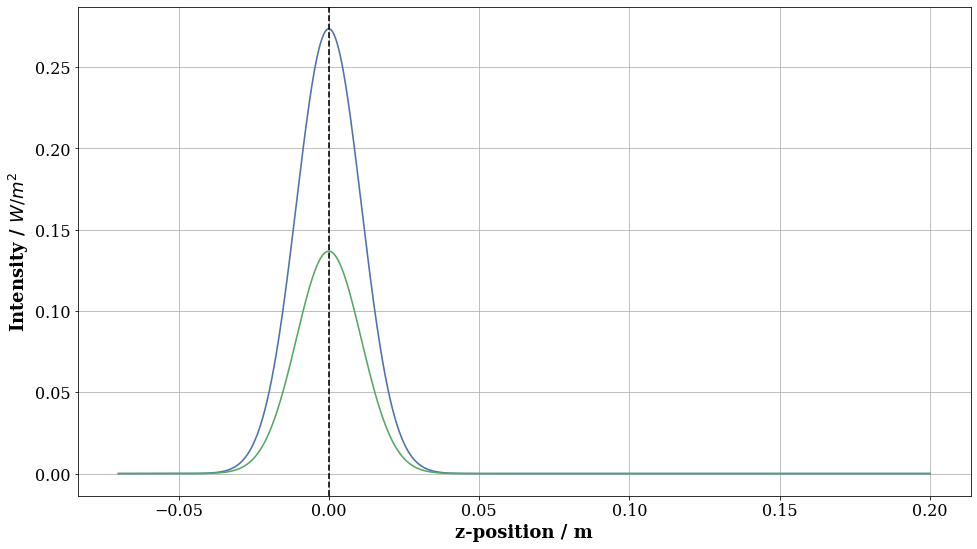

In [47]:
t_array = np.linspace(0, trajectory.get_T(), 1000)
Rs = np.array([trajectory.R_t(t) for t in t_array])
intensities_R = np.array([mf01.intensity.I_R(trajectory.R_t(t)) for t in t_array])
intensities = np.array([mf01.intensity.I_R(np.array([0.0,0.0127,z])) for z in Rs[:,2]])

fig, ax = plt.subplots()
ax.plot(Rs[:,2],intensities_R)
ax.plot(Rs[:,2],intensities)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Intensity / $W/m^2$")
ax.axvline(x = R0[2], ls ='--', c = 'k')

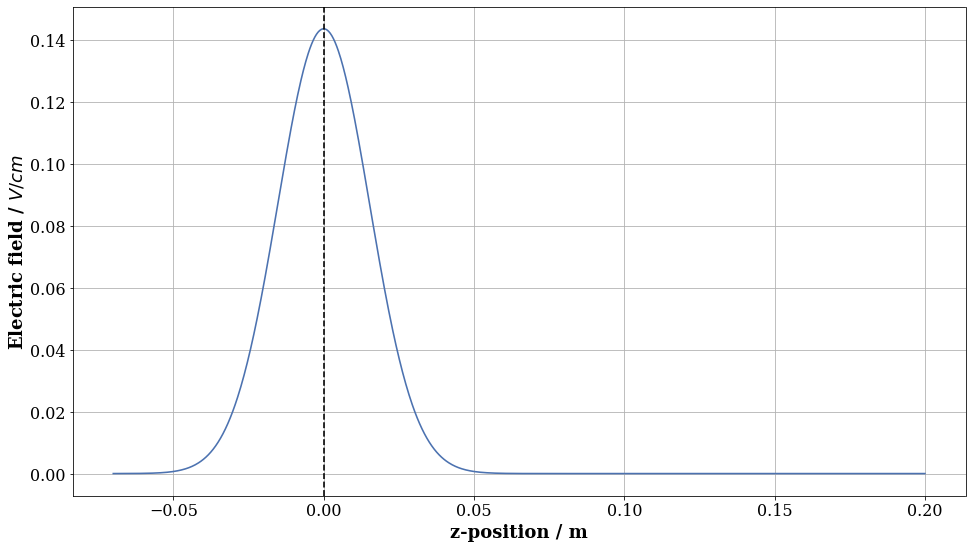

In [48]:
E_mags_R = np.array([mf01.intensity.E_R(trajectory.R_t(t)) for t in t_array])
E_mags = np.array([mf01.intensity.E_R(np.array((0.,0.0,z))) for z in Rs[:,2]])

fig, ax = plt.subplots()
ax.plot(Rs[:,2], E_mags_R)
# ax.plot(Rs[:,2], E_mags)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Electric field / $V/cm$")
ax.axvline(x = R0[2], ls ='--', c = 'k')

### Plot polarization components as function of position
Check that the longitudinal polarization appears correctly

C:\Users\Oskari\Anaconda3\envs\state_prep\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


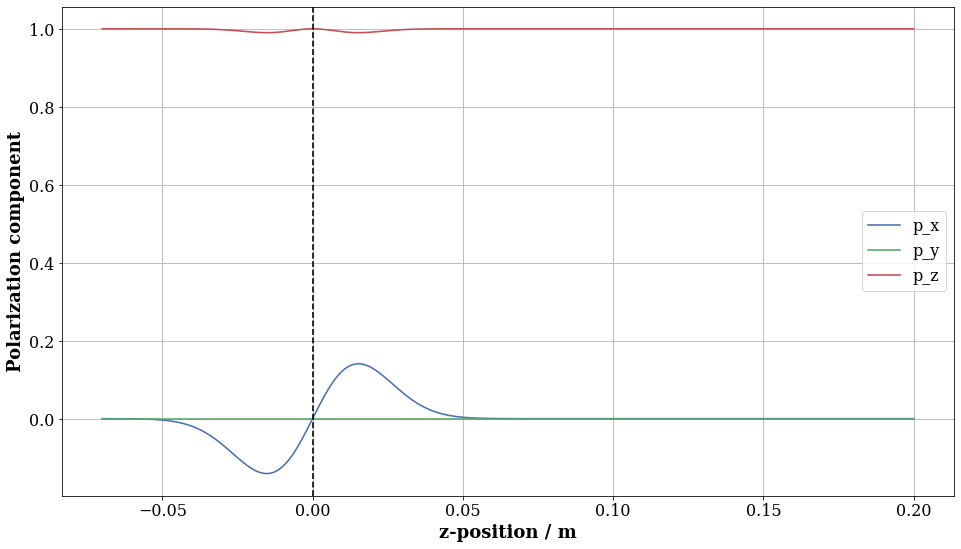

In [49]:
pols = np.array([mf01.polarization.p_R(trajectory.R_t(t), mf01.intensity, freq=muW_freq) for t in t_array])

fig, ax = plt.subplots()
ax.plot(Rs[:,2], np.imag(pols[:,0]), label='p_x')
ax.plot(Rs[:,2], pols[:,1], label='p_y')
ax.plot(Rs[:,2], np.real(pols[:,2]), label='p_z')
ax.legend()
ax.set_xlabel("z-position / m")
ax.set_ylabel("Polarization component")
ax.axvline(x = R0[2], ls ='--', c = 'k')

## Parameter scans
### Helper functions
Define two helper function to run the power scans:

In [73]:
def run_simulation(power: float, detuning: float, R0: np.ndarray, Rini:np.ndarray, Vini: np.ndarray, initial_state_idx: int, target_state: centrex_TlF.State, save_path: Path = None, N_steps = 10000):
    """
    Runs the simulation for one value of power and finds the probability of ending up in the target state.
    """
    ## Microwave settings    
    # Set position
    mf01.set_position(R0)
    
    # Set frequency
    freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
    mf01.set_frequency(freq + detuning)
    mf01_bg.set_frequency(freq + detuning)
    mf01.set_position(R0)

    # Set power
    mf01.set_power(power)
    mf01_bg.intensity.intensity = mf01.intensity.I_R(R0)/70
    
    # Trajectory settings
    trajectory.Rini = Rini
    trajectory.Vini = Vini
    
    # Run the simulator
    result = simulator.run(N_steps = N_steps)
    
    # Save result if save path provided
    if save_path:
        result.save_to_pickle(save_path)
    
    # Determine probability to be in initial state
    prob_ini = result.get_state_probability(result.initial_states[initial_state_idx], initial_state = result.initial_states[initial_state_idx])[-1]

    # Determine probability to be in target state
    prob_fin = result.get_state_probability(target_state, initial_state = result.initial_states[initial_state_idx])[-1]
    
    # Return a dataframe
    df = pd.DataFrame({"power":[power], "detuning":[detuning], "muw_position": [R0], "Rini":[Rini], "Vini":[Vini],  "prob_ini":[prob_ini], "prob_fin": [prob_fin], "save_path": [save_path]})
    
    return df

In [74]:
# Define the function to be run in parallel
def parallel_func(power = 10**(-4.1), detuning = 0, R0 = np.array([0.00,0,-0.0]), Rini = np.array((0,0,-80e-3)), Vini = np.array((0,0,184.)), save = False, N_steps = 10000):
    save_path = SAVE_DIR / Path(f"result_{generate_random_key()}") if save else None
    return run_simulation(power, detuning, R0, Rini, Vini, 0, J1_singlet, save_path=save_path, N_steps = N_steps)

In [75]:
# Function for generating random keys for the results
def generate_random_key(length: int = 6):
    return ''.join(random.choices(string.ascii_letters + string.digits, k = length))

In [76]:
run_simulation(mf01.intensity.power, 0, np.array([0,0,-0.02]), trajectory.Rini, trajectory.Vini, 0, J1_singlet)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:29<00:00, 340.99it/s]


,power,detuning,muw_position,Rini,Vini,prob_ini,prob_fin,save_path
0,0.0002,0,"[0.0, 0.0, -0.02]","[0.0, 0.0, -0.07]","[0, 0, 184]",0.104817,0.895148,None


### Save directory

In [32]:
SAVE_DIR = Path('../results/SPA1 - parameter scans')

### Power values

### Power scan

In [77]:
powers = 10**((np.linspace(-50,10,36)-30)/10) # in W

# Initialize parallel loop
df = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=power, detuning = 2e6,) for power in powers)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  36 out of  36 | elapsed:  2.7min finished


Text(0, 0.5, 'SPA1 efficiency')

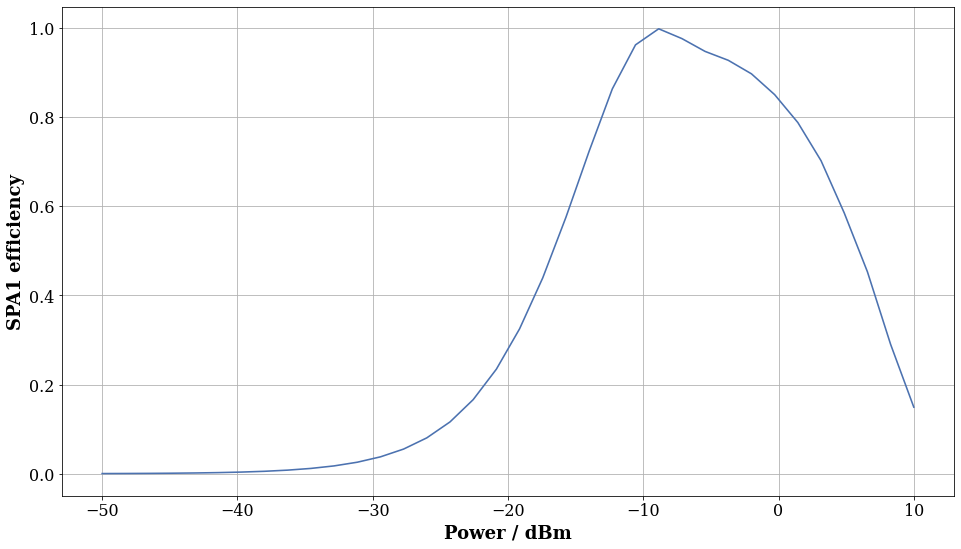

In [78]:
fig, ax = plt.subplots()
ax.plot(10*np.log10(df.power)+30, df.prob_fin)
ax.set_xlabel("Power / dBm")
ax.set_ylabel("SPA1 efficiency")

### Run frequency scan

In [282]:
# Define detunings
deltas = np.linspace(-10, 10, 41)*1e6 # in Hz

In [287]:
# run simulations for different parameters
df_freq = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=1e-4, detuning=delta, R0 = np.array([0,0,0.0]), N_steps=10000) for delta in deltas)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  41 out of  41 | elapsed:  3.3min finished


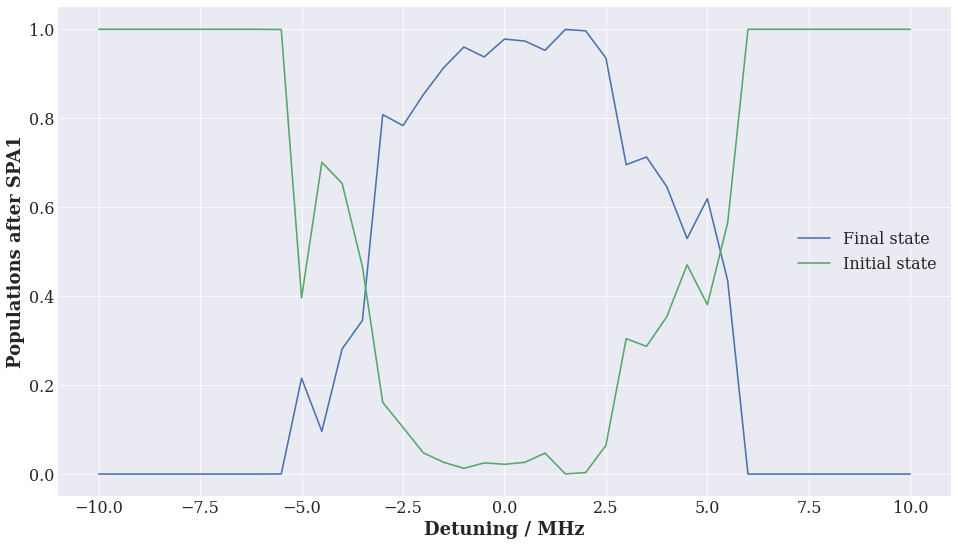

In [299]:
fig, ax = plt.subplots()
ax.plot(df_freq.detuning/1e6, df_freq.prob_fin, label = 'Final state')
ax.plot(df_freq.detuning/1e6, df_freq.prob_ini, label = 'Initial state')
ax.set_xlabel("Detuning / MHz")
ax.set_ylabel("Populations after SPA1")
ax.grid(True)
ax.legend()

In [289]:
df_freq['detuningMHz'] = df_freq.detuning/1e6
df_freq['powermW'] = df_freq.power*1e3

In [290]:
df_freq.to_csv(SAVE_DIR / Path('detuning_scan_with_bg_xypol_at_1e-4W_offset_E_field.csv'))

## Frequency scan convoluted with position and velocity

In [47]:
# Define values for initial y-positions, velocoties and detunings
ypositions = np.linspace(-4,4,9)*1e-3
vzs = np.linspace(150,250,21)
deltas = np.linspace(-10, 10, 41)*1e6 # in Hz

params = product(ypositions, vzs, deltas)

In [48]:
df_conv = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=5e-4, detuning=delta, Rini = np.array([0,ypos,-80e-3]), Vini = np.array([0,0,vzini])) for ypos, vzini, delta in params)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  2.5min
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed: 12.3min
[Parallel(n_jobs=9)]: Done 432 tasks      | elapsed: 28.2min
[Parallel(n_jobs=9)]: Done 782 tasks      | elapsed: 51.2min
[Parallel(n_jobs=9)]: Done 1232 tasks      | elapsed: 80.1min
[Parallel(n_jobs=9)]: Done 1782 tasks      | elapsed: 114.9min
[Parallel(n_jobs=9)]: Done 2432 tasks      | elapsed: 156.0min
[Parallel(n_jobs=9)]: Done 3182 tasks      | elapsed: 203.4min
[Parallel(n_jobs=9)]: Done 4032 tasks      | elapsed: 257.2min
[Parallel(n_jobs=9)]: Done 4982 tasks      | elapsed: 317.0min
[Parallel(n_jobs=9)]: Done 6032 tasks      | elapsed: 383.3min
[Parallel(n_jobs=9)]: Done 7182 tasks      | elapsed: 455.9min
[Parallel(n_jobs=9)]: Done 7749 out of 7749 | elapsed: 491.5min finished


In [49]:
df_conv

,power,detuning,muw_position,Rini,Vini,prob_ini,prob_fin,save_path
0,0.0005,-10000000.0,"[0.0, 0.0, -0.0]","[0.0, -0.004, -0.08]","[0.0, 0.0, 150.0]",1.000000,1.472782e-07,None
1,0.0005,-9500000.0,"[0.0, 0.0, -0.0]","[0.0, -0.004, -0.08]","[0.0, 0.0, 150.0]",1.000000,4.562644e-07,None
2,0.0005,-9000000.0,"[0.0, 0.0, -0.0]","[0.0, -0.004, -0.08]","[0.0, 0.0, 150.0]",0.999999,7.568462e-07,None
3,0.0005,-8500000.0,"[0.0, 0.0, -0.0]","[0.0, -0.004, -0.08]","[0.0, 0.0, 150.0]",0.999998,2.082471e-06,None
4,0.0005,-8000000.0,"[0.0, 0.0, -0.0]","[0.0, -0.004, -0.08]","[0.0, 0.0, 150.0]",0.999998,2.093645e-06,None
...,...,...,...,...,...,...,...,...
7744,0.0005,8000000.0,"[0.0, 0.0, -0.0]","[0.0, 0.004, -0.08]","[0.0, 0.0, 250.0]",1.000000,4.475547e-08,None
7745,0.0005,8500000.0,"[0.0, 0.0, -0.0]","[0.0, 0.004, -0.08]","[0.0, 0.0, 250.0]",1.000000,1.338654e-10,None
7746,0.0005,9000000.0,"[0.0, 0.0, -0.0]","[0.0, 0.004, -0.08]","[0.0, 0.0, 250.0]",1.000000,1.699925e-10,None
7747,0.0005,9500000.0,"[0.0, 0.0, -0.0]","[0.0, 0.004, -0.08]","[0.0, 0.0, 250.0]",1.000000,3.688515e-10,None


<AxesSubplot:xlabel='detuning'>

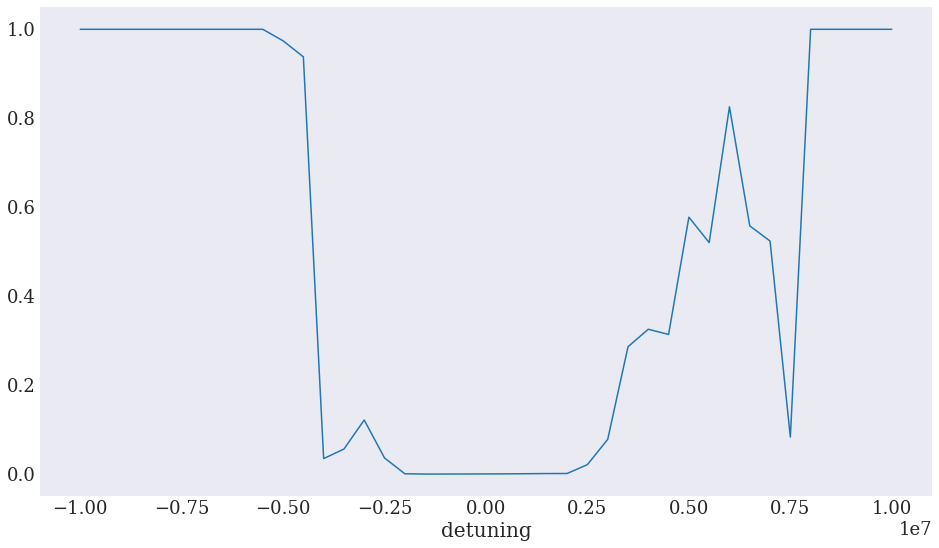

In [53]:
index = df_conv.apply(lambda x: (x.Vini[2] == 200) & (x.Rini[1] == 0), axis = 1)
df_conv[index].groupby('detuning').prob_ini.mean().plot()

In [51]:
# df_conv.to_csv(SAVE_DIR / Path('det_pos_vel_3-31-2022.csv'))

### Frequency scans at different powers

In [93]:
# Define detunings
deltas = np.linspace(-10, 10, 41)*1e6 # in Hz
powers = np.linspace(1,20, 20)*1e-4

params = product(powers, deltas)

In [ ]:
# run simulations for different parameters
df_freq = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=power, detuning=delta, R0 = np.array([0,0,-0.0])) for power, delta in params)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  2.6min


In [ ]:
fig, ax = plt.subplots()
ax.plot(df_freq.detuning/1e6, df_freq.prob_fin, label = 'Final state')
ax.plot(df_freq.detuning/1e6, df_freq.prob_ini, label = 'Initial state')
ax.set_xlabel("Detuning / MHz")
ax.set_ylabel("Populations after SPA1")
ax.grid()
ax.legend()

In [157]:
df_temp = df_freq.copy()

In [84]:
df_temp = pd.read_csv(SAVE_DIR / Path('detuning_scans_at_different_powers.csv'))

In [85]:
df_temp['detuningMHz'] = df_temp.detuning/1e6
df_temp['powermW'] = df_temp.power*1e3

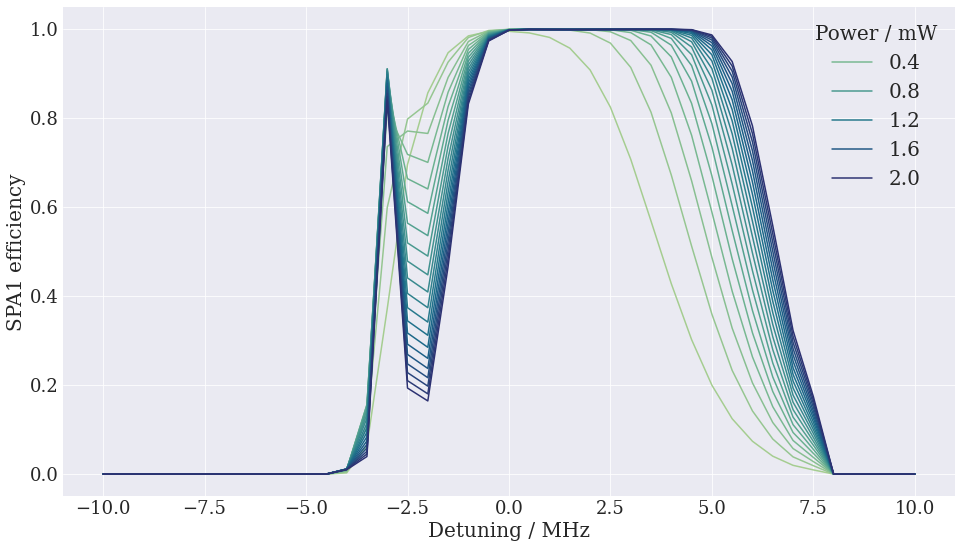

In [86]:
ax = sns.lineplot(data = df_temp, x = 'detuningMHz', y = 'prob_fin', hue = 'powermW', palette='crest')
ax.set_xlabel("Detuning / MHz")
ax.set_ylabel("SPA1 efficiency")
ax.legend(title = 'Power / mW')
ax.grid()

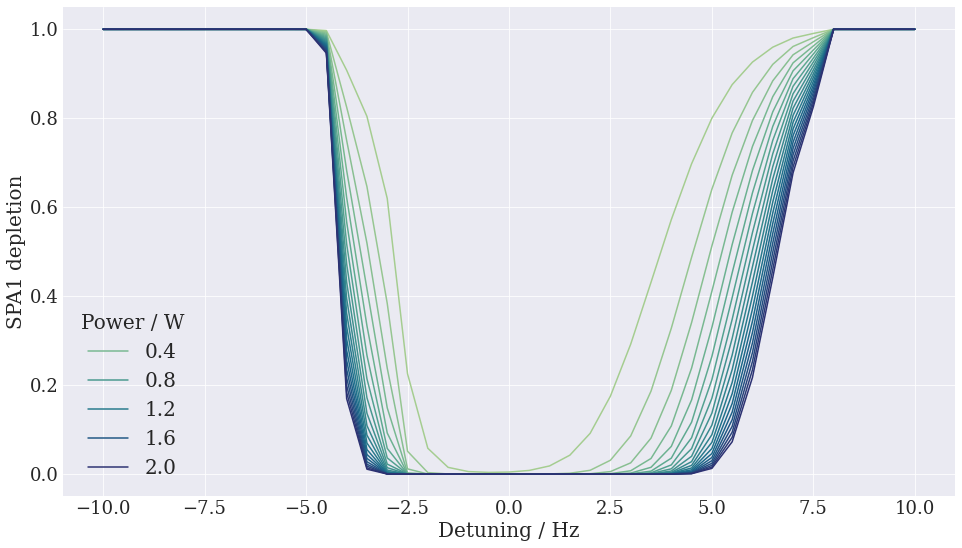

In [87]:
ax = sns.lineplot(data = df_temp, x = 'detuningMHz', y = 'prob_ini', hue = 'powermW', palette='crest')
ax.set_xlabel("Detuning / Hz")
ax.set_ylabel("SPA1 depletion")
ax.legend(title = 'Power / W')
ax.grid()

In [201]:
# df_temp.to_csv(SAVE_DIR / Path('detuning_scans_at_different_powers.csv'))